### TODO
- Everything
- Drop users that have rated very few movies -> How to decide the threshold?
- Define the best approach to the collaborative filtering (model-based or memory-based)
- Build the recommender system (can it be as simple as kNN?)

### DONE
- File loading and creation of the DataFrame

In [8]:
# Imports
import os
import gc
import sys
# from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from surprise import Reader, Dataset, SVD, KNNWithMeans
from surprise.model_selection import cross_validate, GridSearchCV


# # Not being used yet.
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, StratifiedKFold
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.cluster import KMeans
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.pipeline import Pipeline

# from scipy.sparse import csr_matrix

# from scipy.spatial import Voronoi, voronoi_plot_2d
# from imblearn.over_sampling import SMOTE

sns.set_theme(style="darkgrid")

In [9]:
# Read Movie Titles file
def readMovieTitle(file_path):
    data_dict = {'Movie_Id' : [], 'Release_Year' : [], 'Title' : []}
    data_file = open(file_path, "r", encoding='ISO-8859-1')
    for line in data_file:            
        id, year, title = line.split(',', 2)
        data_dict['Movie_Id'].append(id)
        data_dict['Release_Year'].append(year)
        data_dict['Title'].append(title.rstrip('\n'))
    data_file.close()
            
    return pd.DataFrame(data_dict)

In [10]:
# The dataset is very large, so there's a flag to load only a handful of rows if necessary
# First 1M lines takes 0.2s to load, the whole dataset takes almost 2 minutes
def readFile(file_path, rows = 1000000, flag = False):
    data_dict = {'Cust_Id' : [], 'Movie_Id' : [], 'Rating' : [], 'Date' : []}
    data_file = open(file_path, "r")
    count = 0
    for line in data_file:
        count += 1
        if flag and (count > rows):
            break
            
        if ':' in line:
            movieId = line[:-2] # remove the last character ':'
            movieId = int(movieId)
        else:
            customerID, rating, date = line.split(',')
            data_dict['Cust_Id'].append(customerID)
            data_dict['Movie_Id'].append(movieId)
            data_dict['Rating'].append(rating)
            data_dict['Date'].append(date.rstrip("\n"))
    data_file.close()
            
    return pd.DataFrame(data_dict)

In [11]:
# Load the title of the movies into a dataframe
df_title = readMovieTitle('data/movie_titles.csv')
df_title['Movie_Id'] = df_title['Movie_Id'].astype(int)
df_title.head(10)
# df_title.loc[df_title['Movie_Id'] == 1]

,Movie_Id,Release_Year,Title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
5,6,1997,Sick
6,7,1992,8 Man
7,8,2004,What the #$*! Do We Know!?
8,9,1991,Class of Nuke 'Em High 2
9,10,2001,Fighter


In [12]:
# Loading the user data
# User ID, Movie ID, Rating and Date
flag_limit = False
df1 = readFile('data/combined_data_1.txt', flag = flag_limit)
df2 = readFile('data/combined_data_2.txt', flag = flag_limit)
df3 = readFile('data/combined_data_3.txt', flag = flag_limit)
df4 = readFile('data/combined_data_4.txt', flag = flag_limit)
# Transform everything to INT, occupies less RAM.
df1['Rating'] = df1['Rating'].astype(int)
df2['Rating'] = df2['Rating'].astype(int)
df3['Rating'] = df3['Rating'].astype(int)
df4['Rating'] = df4['Rating'].astype(int)
df1['Cust_Id'] = df1['Cust_Id'].astype(int)
df2['Cust_Id'] = df2['Cust_Id'].astype(int)
df3['Cust_Id'] = df3['Cust_Id'].astype(int)
df4['Cust_Id'] = df4['Cust_Id'].astype(int)

In [13]:
# Creation of the DataFrame with all the data
df = df1.copy()
df = pd.concat([df1, df2, df3, df4])
df.index = np.arange(0,len(df))
df.head(10)
# Drop everything but the essential information
df = df.loc[:, ['Cust_Id', 'Movie_Id', 'Rating']]

# # Complete Dataframe with the movie titles
# # Not necessary
# df = df.merge(df_title, how='left')
# df = df.loc[:, ['Cust_Id', 'Movie_Id', 'Title', 'Release_Year', 'Rating', 'Date']]
# df.head(-10)

# Too much data, so I'm deleting the dataframes after the merge
# In total it uses 14gb of memory
del df1, df2, df3, df4, # df_title
# Explicitily calling the garbage collector to free up RAM
gc.collect()

0

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100480507 entries, 0 to 100480506
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   Cust_Id   int64
 1   Movie_Id  int64
 2   Rating    int64
dtypes: int64(3)
memory usage: 3.0 GB


After the successful loading of the data into a single large dataframe, now it's time to understand the data and do a little bit of a clean up (delete rows with NaN values, look for duplicates, drop unnecessary columns etc.)

In [15]:
# General format of the Dataframe
df.head(10)

,Cust_Id,Movie_Id,Rating
0,1488844,1,3
1,822109,1,5
2,885013,1,4
3,30878,1,4
4,823519,1,3
5,893988,1,3
6,124105,1,4
7,1248029,1,3
8,1842128,1,4
9,2238063,1,3


In [16]:
df.shape

(100480507, 3)

In [ ]:
# Check if there are empty rows
# Not necessary, data is clean
#df.isna().sum()

In [ ]:
# Check if there are duplicated values
# Not necessary, data is clean
# df.duplicated().sum()
# If there were duplicates
# df = df.loc[~df.duplicated()].reset_index(drop=True).copy()

In [17]:
# Check the type of the variables.
# Here we identify that some are loaded as a type we don't want and thus need to transform it
# Int occupies less memory
df.dtypes

Cust_Id     int64
Movie_Id    int64
Rating      int64
dtype: object

In [ ]:
# Changing the types -> already did during loading, not necessary
# df['Cust_Id'] = df['Cust_Id'].astype(int)
# df['Release_Year'] = df['Release_Year'].astype(int)
# df['Date'] = pd.to_datetime(df['Date'])
# gc.collect()
# df.dtypes

Now the dataset is clean (it already was, but nonetheless this should be part of the pipeline)
Let's investigate the data, i.e. do Feature Understanding
Histogram, KDE, Boxplot

In [91]:
df.groupby('Movie_Id')['Rating'].count().sort_values(ascending=True).mean()

5654.502363534046

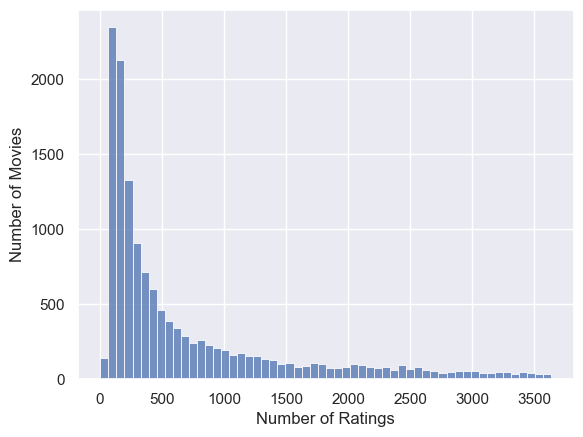

In [90]:
mr = df.groupby('Movie_Id')['Rating'].count().sort_values(ascending=True).head(14000)

ax = sns.histplot(data=mr)
ax.bar_label(ax.containers[0])
plt.axis('on')
plt.xlabel('Number of Ratings')
plt.xscale('linear')
plt.ylabel('Number of Movies')
plt.show()

In [88]:
mr.tail(10)

df_title.loc[(df_title['Movie_Id'] == 5317)]

,Movie_Id,Release_Year,Title
5316,5317,2000,Miss Congeniality


In [ ]:
# Number of unique movies
movie_count = df['Movie_Id'].nunique()

# Number of unique customers
cust_count = df['Cust_Id'].nunique()

# Number of ratings
rating_count = df['Cust_Id'].count()

# How many ratings for each value (1-5)
rating_dist = df['Rating'].value_counts().sort_index()

In [ ]:
# Histogram of the frequency of ratings
rd = [(i/sum(rating_dist)*100) for i in rating_dist]

ax = sns.barplot(x = np.arange(1,len(rd)+1), y = rd)
ax.bar_label(ax.containers[0], fmt = '%.1f%%')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.axis('on')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Histogram of the frequency of reviews by users
cust_rating_dist = df['Cust_Id'].value_counts().sort_values()

crd = cust_rating_dist.value_counts().sort_index()

ax = sns.barplot(x = np.arange(len(crd)), y = crd) 
plt.show()

The data is pretty huge, after understanding it's intrincacies, we've decided to work only with the movies and users that were in the 75% quantile

In [ ]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.75),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.75),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

In [ ]:
# Checking the favorite movies of a random user (df['Cust_Id'].mode() -> users with most reviews)
df.loc[(df['Cust_Id'] == 305344) & (df['Rating'] >= 4)].reset_index(drop=True)

In [ ]:
# Creating the dataset inside Surprise
# Surprise accepts by default only this 3 parameters \/
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainingSet = data.build_full_trainset()

In [ ]:
# Using SVD for recomendation
# Copied this online -> don't fully understand.
svd = SVD()
user_305344 = df_title.copy()
user_305344 = user_305344.reset_index()

svd.fit(trainingSet)

user_305344['Estimate_Score'] = user_305344['Movie_Id'].apply(lambda x: svd.predict(305344, x).est)

# user_305344 = user_305344.drop('Movie_Id', axis = 1)

user_305344 = user_305344.sort_values('Estimate_Score', ascending=False)
print(user_305344[['Movie_Id', 'Title', 'Estimate_Score']].head(20))

In [ ]:
# reader = Reader(rating_scale=(1, 5))
# svd = SVD()

# data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:], reader)
# #data.split(n_folds=3)

# cross_validate(svd, data, measures=['RMSE', 'MAE'])

In [ ]:
# # Grid Search to find the best parameters for SVD
# param_grid = {
#     "n_epochs": [5, 10],
#     "lr_all": [0.002, 0.005],
#     "reg_all": [0.4, 0.6]
# }
# gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)

# gs.fit(data)

# print(gs.best_score["rmse"])
# print(gs.best_params["rmse"])

In [ ]:
# # Appplying Best Parameters to predict the score of the same movie and user predicted by kNN
# algo = gs.best_estimator["rmse"]
# algo.fit(data.build_full_trainset())

# prediction = algo.predict(305344, 9235)
# print(prediction.est)